Environment Type: reactive
Runtime: 23.94481110572815

Average Reward across all scenarios: -12072.93


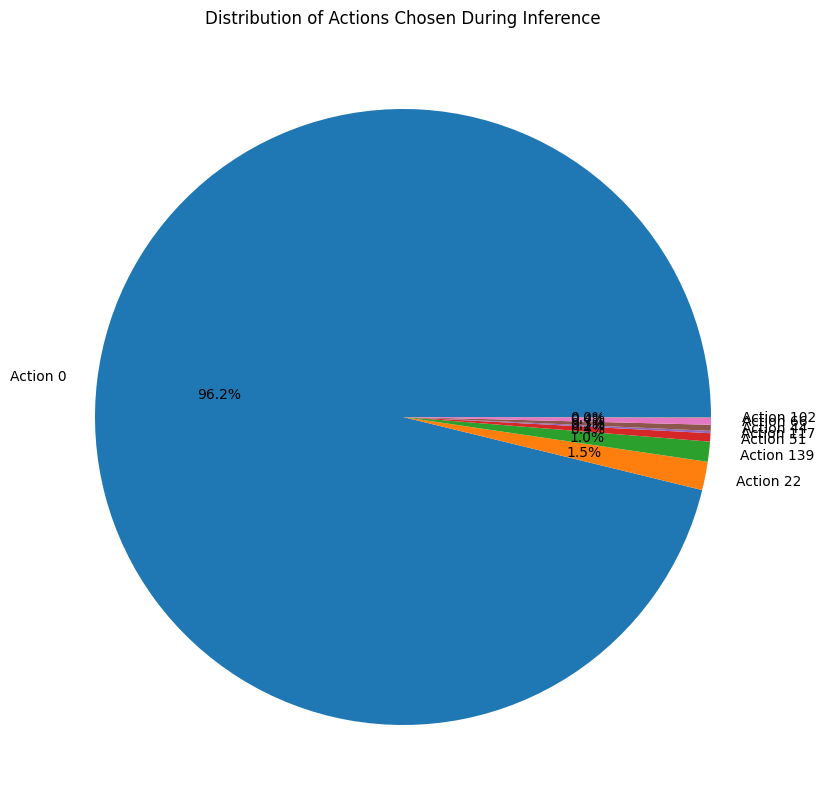

In [9]:
import os
import numpy as np
from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data, get_training_metadata, NumpyEncoder
from src.config import *
import re
import torch
import time
import ipywidgets as widgets
from IPython.display import display, clear_output, Image as IPImage
from io import BytesIO
import matplotlib.pyplot as plt

from scripts.logger import create_new_id, log_inference_metadata, log_inference_scenario_data, find_corresponding_training_id, get_config_variables, convert_to_serializable, update_id_status
import src.config as config
from datetime import datetime
import json

blabla_reward = {}

def run_inference_dqn_single(model_path, scenario_folder, env_type, seed):
    """
    Runs inference on a single scenario and logs detailed results.

    Args:
        model_path (str): Path to the trained model.
        scenario_folder (str): Path to the scenario folder.
        env_type (str): Type of environment ("myopic" or "proactive").
        seed (int): Seed for reproducibility.
    """
    # Load scenario data
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )

    # Load trained model and configure
    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize visualization
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    # Scenario log
    scenario_log = {
        "scenario_folder": scenario_folder,
        "env_type": env_type,
        "seed": seed,
        "steps": [],
        "total_reward": 0,
        "runtime_start": datetime.utcnow().isoformat() + "Z",
    }

    while not done_flag and step_num < max_steps:
        # Step-level pre-action info
        step_info_before_action = {
            "num_cancelled_flights": len(env.cancelled_flights),
            "num_delayed_flights": len(env.environment_delayed_flights),
            "num_resolved_conflicts": len(env.resolved_conflicts),
            "current_datetime": env.current_datetime.isoformat(),
        }

        # Action selection
        action_mask = obs['action_mask']
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()
        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        action = np.argmax(masked_q_values)

        if action_mask[action] == 0:
            raise ValueError(f"Invalid action selected: {action}")

        # Environment step
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        action_mapped = env.map_index_to_action(action)

        # Log step data
        step_log = {
            "step_num": step_num,
            "action": action,
            "flight_action": action_mapped[0],
            "aircraft_action": action_mapped[1],
            "reward": reward,
            "total_reward": total_reward,
            "q_values": q_values.tolist(),
            "masked_q_values": masked_q_values.tolist(),
            "action_mask": action_mask.tolist(),
            "done_flag": done_flag,
            "info_after_step": convert_to_serializable(env.info_after_step),
            "step_info_before_action": step_info_before_action,
        }

        scenario_log["steps"].append(step_log)
        step_num += 1

    scenario_log["total_reward"] = total_reward
    scenario_log["runtime_end"] = datetime.utcnow().isoformat() + "Z"

    blabla_reward[scenario_folder] = scenario_log

    return blabla_reward


def run_inference_dqn_folder(model_path, scenario_folder, env_type, seed):
    """
    Runs inference on all scenarios in a folder.

    Args:
        model_path (str): Path to the trained model.
        scenario_folder (str): Path to the folder containing scenarios.
        env_type (str): Type of environment ("myopic" or "proactive").
        seed (int): Seed for reproducibility.
    """
    runtime_start = time.time()

    for scenario in os.listdir(scenario_folder):
        scenario_path = os.path.join(scenario_folder, scenario)
        if os.path.isdir(scenario_path):
            blabla_reward = run_inference_dqn_single(model_path, scenario_path, env_type, seed)

    runtime_end = time.time()
    print(f"Runtime: {runtime_end - runtime_start}")
    return blabla_reward


# Main logic to run inference
latest = True
env_type = "reactive"

seed = int(time.time())
SCENARIO_FOLDER = "../data/Locked/alpha/"

# PROACTIVE EXAMPLE
SCENARIO_FOLDER ="../data/TEMP/6ac-700-diverse/"

# ACTUALLY WORKING
MODEL_PATH = "../trained_models/dqn/6ac-700-diverse/71/reactive-training_61.zip"

print(f"Environment Type: {env_type}")

blabla_reward = run_inference_dqn_folder(MODEL_PATH, SCENARIO_FOLDER, env_type, seed)

# Calculate and print average reward
rewards = [data["total_reward"] for data in blabla_reward.values()]
avg_reward = sum(rewards) / len(rewards) if rewards else 0
print(f"\nAverage Reward across all scenarios: {avg_reward:.2f}")

# Create pie chart of action distribution
action_counts = {}
for scenario_data in blabla_reward.values():
    for step in scenario_data["steps"]:
        action = step["action"]
        action_counts[action] = action_counts.get(action, 0) + 1

if action_counts:
    plt.figure(figsize=(10, 10))
    plt.pie(action_counts.values(), labels=[f'Action {k}' for k in action_counts.keys()], autopct='%1.1f%%')
    plt.title('Distribution of Actions Chosen During Inference')
    plt.show()



Average Reward across all scenarios: -17508.56
